# Backpropagation Lab





## 1. (40%) Correctly implement and submit your own code for the backpropagation algorithm. 

## Code requirements 
- Ability to create a network structure with at least one hidden layer and an arbitrary number of nodes.
- Random weight initialization with small random weights with mean of 0 and a variance of 1.
- Use Stochastic/On-line training updates: Iterate and update weights after each training instance (i.e. do not attempt batch updates)
- Implement a validation set based stopping criterion.
- Shuffle training set at each epoch.
- Option to include a momentum term

You may use your own random train/test split or use the scikit-learn version if you want.

Use your Backpropagation algorithm to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your script on the Evaluation data with the same parameters, and print your final weights.

In [297]:
import io
import random

from scipy.io import arff
import urllib
import math
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

class MLP(BaseEstimator,ClassifierMixin):

    def __init__(self,lr=.1, momentum=0, shuffle=True,hidden_layer_widths=None,binary=False,one_hot=False, epochs_wo_improvement=40):
        """ Initialize class with chosen hyperparameters.

        Args:
            lr (float): A learning rate / step size.
            shuffle(boolean): Whether to shuffle the training data each epoch. DO NOT SHUFFLE for evaluation / debug datasets.
            momentum(float): The momentum coefficent 
        Optional Args (Args we think will make your life easier):
            hidden_layer_widths (list(int)): A list of integers which defines the width of each hidden layer if hidden layer is none do twice as many hidden nodes as input nodes. (and then one more for the bias node)
            For example: input width 1, then hidden layer will be 3 nodes
        Example:
            mlp = MLP(lr=.2,momentum=.5,shuffle=False,hidden_layer_widths = [3,3]),  <--- this will create a model with two hidden layers, both 3 nodes wide
        """
        self.hidden_layer_widths = hidden_layer_widths
        self.lr = lr
        self.momentum = momentum
        self.shuffle = shuffle
        self.weights = []
        self.prev_change_in_weights = []
        self.output_converter = np.vectorize(_apply_output_single_node)
        self.f_prime_converter = np.vectorize(_get_f_prime_of_output)

        self.runs_left = 0
        self.is_deterministic = False

        # self.best_val_score = 0
        self.best_val_score = 1
        self.num_epochs_wo_sig_imp = 0

        self.binary = binary
        self.one_hot = one_hot

        self.training_mse_by_epoch = []
        self.testing_mse_by_epoch = []
        self.validation_mse_by_epoch = []
        self.training_acc_by_epoch = []
        self.testing_acc_by_epoch = []
        self.validation_acc_by_epoch = []

        self.max_num_epochs_wo_improvement = epochs_wo_improvement
        self.bssf_weights = []
        self.bssf_epochs = -1

    def reset(self):
        self.weights = []
        self.prev_change_in_weights = []
        self.output_converter = np.vectorize(_apply_output_single_node)
        self.f_prime_converter = np.vectorize(_get_f_prime_of_output)

        self.runs_left = 0
        self.is_deterministic = False

        # self.best_val_score = 0
        self.best_val_score = 1
        self.num_epochs_wo_sig_imp = 0

        self.training_mse_by_epoch = []
        self.testing_mse_by_epoch = []
        self.validation_mse_by_epoch = []
        self.training_acc_by_epoch = []
        self.testing_acc_by_epoch = []
        self.validation_acc_by_epoch = []

        self.bssf_weights = []
        self.bssf_epochs = -1

    def fit(self, X, y, gaussian=True, initial_weights=None, deterministic=0, val_perc=.15, get_mses=False, X_test=None, y_test=None):
        """ Fit the data; run the algorithm and adjust the weights to find a good solution

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Optional Args (Args we think will make your life easier):
            initial_weights (array-like): allows the user to provide initial weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)

        """
        X_train = []
        y_train = []
        X_validate = []
        y_validate = []
        self.X_test = X_test
        self.y_test = y_test
        if deterministic != 0:
            self.is_deterministic = True
            self.runs_left = deterministic
            X_train = X
            y_train = y
        else:
            X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=val_perc)

        self.weights = self.initialize_weights(X_train, y_train, gaussian) if not initial_weights else initial_weights
        self._init_prev_change_in_weights()
        X_with_bias = self._add_bias_to_matrix(X_train)

        while not self.stopping_criteria_met(X_validate, y_validate):
            if self.shuffle:
                X_train, y_train = self._shuffle_data(X_train, y_train)
                X_with_bias = self._add_bias_to_matrix(X_train)
            # Go through all data once
            for data_row in range(0, len(X_with_bias)):
                # Get the current row of data
                cur_inputs = np.array(X_with_bias[data_row])
                cur_targets = np.array(y_train[data_row])

                # Get the outputs (Z) for the whole net
                iteration_outputs = self._get_iteration_outputs(cur_inputs)

                # Get the errors (delta) for the whole net (output and hidden have different formulas)
                output_errors = self._get_all_output_nodes_errors(cur_targets, iteration_outputs[len(iteration_outputs)-1])
                hidden_node_errors = self._get_all_hidden_node_errors(iteration_outputs, output_errors)

                # Update the weights
                all_errors = hidden_node_errors.copy()
                all_errors.append(output_errors)
                inputs_wo_bias = np.array(X_train[data_row])
                all_but_final_output = [inputs_wo_bias]
                all_but_final_output.extend(iteration_outputs[:-1])
                self._update_all_weights(all_errors, all_but_final_output)

            if get_mses:
                if X_test is None:
                    raise Exception
                self.update_mses(X_train, y_train, X_validate, y_validate, X_test, y_test)
                self._get_epoch_accuracies(X_train, y_train, X_validate, y_validate, X_test, y_test)

        if get_mses:
            self.weights = self.bssf_weights

        return self

    def stopping_criteria_met(self, X_validate, y_validate):
        if self.is_deterministic:
            self.runs_left -= 1
            if self.runs_left < 0:
                return True
            else:
                return False
        else:
            # validation_score = self.score(X_validate, y_validate)
            # if validation_score > self.best_val_score:
            validation_score = self._get_data_set_mse(X_validate, y_validate)
            if validation_score < self.best_val_score:
                self.best_val_score = validation_score
                self.bssf_weights = self.weights.copy()
                self.bssf_epochs = self.bssf_epochs + self.num_epochs_wo_sig_imp + 1
                self.num_epochs_wo_sig_imp = 0
            else:
                self.num_epochs_wo_sig_imp += 1

            if self.num_epochs_wo_sig_imp >= self.max_num_epochs_wo_improvement or validation_score < 0.001:
                return True
            else:
                return False



    def predict(self, X):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        X_with_bias = self._add_bias_to_matrix(X)
        num_data_points, _ = X_with_bias.shape
        outputs_to_return = []
        for data_index in range(0, num_data_points):
            outputs = self._get_iteration_outputs(X_with_bias[data_index])
            final_outputs = outputs.pop()
            if self.one_hot:
                curMax = None
                curMaxIndex = None
                for i in range(0,len(final_outputs)):
                    if curMax == None:
                        curMax = final_outputs[i]
                        curMaxIndex = i
                    else:
                        if final_outputs[i] > curMax:
                            final_outputs[curMaxIndex] = 0
                            curMax = final_outputs[i]
                            curMaxIndex = i
                        else:
                            final_outputs[i] = 0
                final_outputs[curMaxIndex] = 1
            if self.binary:
                final_outputs = round(final_outputs.item(0))
            outputs_to_return.append(final_outputs)
        if self.binary:
            return np.array(outputs_to_return, ndmin=2).T
        return np.array(outputs_to_return)

    def initialize_weights(self, X, y, gaussian):
        """ Initialize weights for perceptron. Don't forget the bias!

        Returns:

        """
        _, num_features = X.shape
        _, num_outputs = y.shape
        if self.hidden_layer_widths == None:
            self.hidden_layer_widths = [num_features * 2]
        weights = []
        input_layer_weights = self._initialize_single_array(num_features + 1, self.hidden_layer_widths[0], gaussian)

        weights.append(input_layer_weights)

        for i in range(0, len(self.hidden_layer_widths)-1):
            cur_layer_weights = self._initialize_single_array(self.hidden_layer_widths[i]+1,self.hidden_layer_widths[i+1], gaussian)
            weights.append(cur_layer_weights)

        output_layer_weights = self._initialize_single_array(self.hidden_layer_widths[len(self.hidden_layer_widths)-1] + 1, num_outputs, gaussian)
        weights.append(output_layer_weights)

        return weights

    def score(self, X, y):
        """ Return accuracy of model on a given dataset. Must implement own score function.

        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets

        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        guesses = self.predict(X)
        if self.one_hot:
            num_rows, _ = y.shape
            guessedCorrectly = 0
            for i in range(0, len(X)):
                guessIndex = np.where(guesses[i] == 1)[0].item(0)
                realIndex = np.where(y[i] == 1)[0].item(0)
                if guessIndex == realIndex:
                    guessedCorrectly += 1
            return guessedCorrectly / num_rows
        else:
            accuracies = y == guesses
            correct = np.count_nonzero(accuracies == True)
            return correct / y.size

    def _shuffle_data(self, X, y):
        """ Shuffle the data! This _ prefix suggests that this method should only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D array, rather than
             shuffling X and y exactly the same way, independently.
        """
        shuffledX, shuffledY = shuffle(X, y)
        return shuffledX, shuffledY

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.weights

    def _initialize_single_array(self, rows, cols, gaussian):
        if gaussian:
            return np.random.normal(loc=0.0, scale=0.001, size=(rows,cols))
        else:
            return np.zeros((rows, cols))

    def _add_bias_to_matrix(self, npArray):
        _, num_cols = npArray.shape
        return np.insert(npArray, num_cols, 1, axis=1)

    def _get_iteration_outputs(self, inputs_with_bias):
        cur_inputs = inputs_with_bias
        outputs = []
        for i in range(0,len(self.weights)):
            cur_layer_net = cur_inputs.dot(self.weights[i])
            cur_layer_out = self._apply_output_function(cur_layer_net)
            outputs.append(cur_layer_out)
            if cur_layer_out.ndim == 1:
                cur_inputs = np.insert(cur_layer_out, len(cur_layer_out), 1)
            else:
                _, num_cols = cur_layer_out.shape
                cur_inputs = np.insert(cur_layer_out, num_cols, 1, axis=1)

        return outputs

    def _apply_output_function(self, net_array):
        return self.output_converter(net_array)

    def _get_all_output_nodes_errors(self, cur_targets, final_outputs):
        num_outputs = final_outputs.shape[0]
        output_errors = []
        for i in range(0, num_outputs):
            output_errors.append(self._get_output_node_error(cur_targets[i], final_outputs[i]))
        return np.array(output_errors)

    def _get_output_node_error(self, target, output):
        return (target - output) * (output) * (1 - output)

    def _get_all_hidden_node_errors(self, all_outputs, output_errors):
        k_errors = output_errors
        hidden_node_errors = []
        for i in range(len(all_outputs)-2, -1, -1):
            j_outputs = all_outputs[i]
            j_k_weights = self.weights[i + 1]
            cur_layer_errors = self._get_hidden_node_layer_error(j_outputs, k_errors, j_k_weights)
            hidden_node_errors.append(cur_layer_errors)
            k_errors = cur_layer_errors
        return hidden_node_errors

    def _get_hidden_node_layer_error(self, j_outputs, k_errors, j_k_weights):
        direct_term = np.dot(j_k_weights, k_errors)
        j_f_primes = self.f_prime_converter(j_outputs)
        cur_layer_errors = []
        for i in range(0, len(j_f_primes)):
            cur_layer_errors.append(j_f_primes[i] * direct_term[i])
        return np.array(cur_layer_errors)

    def _update_all_weights(self, all_node_errors, inh_wob_node_outputs):
        for layer_index in range(0, len(all_node_errors)):
            i_j_weights = self.weights[layer_index]
            j_errors = all_node_errors[layer_index]
            i_outputs = np.insert(inh_wob_node_outputs[layer_index], len(inh_wob_node_outputs[layer_index]), 1)
            prev_i_j_change_weights = self.prev_change_in_weights[layer_index]
            self._update_layer_weights(i_j_weights, j_errors, i_outputs, prev_i_j_change_weights)

    def _update_layer_weights(self, layer_weights, j_errors, i_outputs, prev_i_j_change_weights):
        for i in range(0, len(i_outputs)):
            for j in range(0, len(j_errors)):
                new_change_weight = self.lr * j_errors[j] * i_outputs[i] + self.momentum * prev_i_j_change_weights[i][j]
                layer_weights[i][j] += new_change_weight
                prev_i_j_change_weights[i][j] = new_change_weight


    def _init_prev_change_in_weights(self):
        for i in range(0, len(self.weights)):
            num_rows, num_cols = self.weights[i].shape
            self.prev_change_in_weights.append(np.zeros((num_rows, num_cols)))

    def update_mses(self, X_train, y_train, X_validate, y_validate, X_test, y_test):
        train_mse = self._get_data_set_mse(X_train, y_train)
        validate_mse = self._get_data_set_mse(X_validate, y_validate)
        test_mse = self._get_data_set_mse(X_test, y_test)
        self.training_mse_by_epoch.append(train_mse)
        self.validation_mse_by_epoch.append(validate_mse)
        self.testing_mse_by_epoch.append(test_mse)

    def _get_data_set_mse(self, X, y):
        X_with_bias = self._add_bias_to_matrix(X)
        all_pattern_mses = []
        for i in range(0, len(X)):
            cur_targets = y[i]
            all_outputs = self._get_iteration_outputs(X_with_bias[i])
            pattern_mse = self._get_pattern_mse(all_outputs, cur_targets)
            all_pattern_mses.append(pattern_mse)
        X_mse = self._get_mean(all_pattern_mses)
        return X_mse

    def _get_squared_error(self, target, output):
        return (target - output) * (target - output)

    def _get_pattern_mse(self, all_outputs, target):
        final_outputs = all_outputs[-1]
        all_squared_errors = []
        for i in range(0, len(final_outputs)):
            squared_error = self._get_squared_error(target[i], final_outputs[i])
            all_squared_errors.append(squared_error)
        pattern_mse = self._get_mean(all_squared_errors)
        return pattern_mse

    def _get_mean(self, element_list):
        sum = 0.0
        for element in element_list:
            sum += element
        return sum / len(element_list)

    def _get_epoch_accuracies(self, X_train, y_train, X_validate, y_validate, X_test, y_test):
        train_accuracy = self.score(X_train, y_train)
        validate_accuracy = self.score(X_validate, y_validate)
        test_accuracy = self.score(X_test, y_test)
        self.training_acc_by_epoch.append(train_accuracy)
        self.testing_acc_by_epoch.append(test_accuracy)
        self.validation_acc_by_epoch.append(validate_accuracy)

def _get_f_prime_of_output(output):
    return output * (1 - output)

def _apply_output_single_node(net):
    output = 1.0 / (1.0 + math.exp(-net))
    return output

def load_data(url: str):
    ftp_stream = urllib.request.urlopen(url)
    data, meta = arff.loadarff(io.StringIO(ftp_stream.read().decode('utf-8')))
    data_frame = pd.DataFrame(data)
    return data_frame

def remove_bytes(num):
    if type(num) == bytes:
        return ord(num) - 48
    return num

byteRemoverFunction = np.vectorize(remove_bytes)

I provided a few extra options in my multi-layer perceptron model, here is a brief explanation of the non-standard parameters:

Initialization
binary: Used to tell the model how to predict the data (rounding down to 0 or up to 1)
one-hot: Used to tell the model how to predict the data (force a single option of the predicted y values, taking the largest weight option)
epochs_wo_improvement: When running a non-deterministic model, determines how many epochs will pass without improvement before terminating the search

Fit
gaussian: Determines whether the weights will be initialized to zero or to small random numbers normally distributed about zero
get_mses: Tracks the MSE values for the training, validation, and testing data sets
train_x, train_y: Passed in if get_mses is True in order to calculate the MSE values per epoch of the set

On overall explanation of my implementation of the algorithm is given below
Split data into validation and normal set if not deterministic otherwise run for a set number of iterations
Shuffle the training data set
Forward propagate the inputs keeping track of all outputs of each node
Back propagate the errors (output and hidden nodes errors are calculated slightly differently)
Update all weights keeping track of previous weights for momentum

## 1.1 

Debug your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

---

### 1.1.1 Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff)


Expected Results for Binary Classification (i.e. 1 output node): [debug_bp_0.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_0.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 \\ 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 \\ -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 \end{bmatrix}$$
                                             
$$ \text{Layer 2} = \begin{bmatrix} -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.02145495 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

Expected Results for One Hot Vector Classification (i.e. 2 output nodes): [debug_bp_2outs.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_2outs.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -0.00018149 & -0.00018149 & -0.00018149 & -0.00018149 \\ 0.00157468 & 0.00157468 & 0.00157468 & 0.00157468 \\ -0.00788218 & -0.00788218 & -0.00788218 & -0.00788218 \end{bmatrix}$$
                          
$$ \text{Layer 2} = \begin{bmatrix} 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.02148778 & -0.02148778 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

In [298]:
# Load debug data
debug_data = load_data(r'https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff')
debug_data = byteRemoverFunction(debug_data)
X = debug_data[:,:-1]
y = debug_data[:,-1, None]

# Train on binary debug data
debug_mlp_binary = MLP(momentum=0.5, shuffle=False,hidden_layer_widths=[4],binary=True)
debug_mlp_binary.fit(X, y, gaussian=False,deterministic=10)

# Print weights for binary
debug_binary_weights = debug_mlp_binary.get_weights()
print('Binary Encoding Weights')
for i in range(0,len(debug_binary_weights)):
    print(f'Layer {i+1}')
    print(debug_binary_weights[i])

# Train on one hot debug data
debug_enc = OneHotEncoder()
y_hot = debug_enc.fit_transform(y).toarray()
debug_mlp_hot = MLP(momentum=0.5, shuffle=False,hidden_layer_widths=[4],one_hot=True)
debug_mlp_hot.fit(X, y_hot, gaussian=False,deterministic=10)

# Print weights for one-hot
debug_hot_weights = debug_mlp_hot.get_weights()
print()
print('One-Hot Encoding Weights')
for i in range(0,len(debug_hot_weights)):
    print(f'Layer {i+1}')
    print(debug_hot_weights[i])

Binary Encoding Weights
Layer 1
[[-8.81779797e-05 -8.81779797e-05 -8.81779797e-05 -8.81779797e-05]
 [ 7.82757731e-04  7.82757731e-04  7.82757731e-04  7.82757731e-04]
 [-3.94353645e-03 -3.94353645e-03 -3.94353645e-03 -3.94353645e-03]]
Layer 2
[[-0.01060888]
 [-0.01060888]
 [-0.01060888]
 [-0.01060888]
 [-0.02145495]]

One-Hot Encoding Weights
Layer 1
[[-0.00018149 -0.00018149 -0.00018149 -0.00018149]
 [ 0.00157468  0.00157468  0.00157468  0.00157468]
 [-0.00788218 -0.00788218 -0.00788218 -0.00788218]]
Layer 2
[[ 0.01050642 -0.01050642]
 [ 0.01050642 -0.01050642]
 [ 0.01050642 -0.01050642]
 [ 0.01050642 -0.01050642]
 [ 0.02148778 -0.02148778]]


There is not much to note here for discussion. My weight layers are arranged (outgoing node x incoming node) from input side of the net to output.

### 1.1.2 Evaluation

Evaluate your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

We will evaluate your model based on printed weights after training on the [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff)

In [299]:
# Load evaluation data
eval_data = load_data(r'https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff')
eval_data = byteRemoverFunction(eval_data)
X = eval_data[:,:-1]
y = eval_data[:,-1, None]

# Train on binary evaluation data
eval_mlp_binary = MLP(momentum=0.5, shuffle=False,hidden_layer_widths=[4],binary=True)
eval_mlp_binary.fit(X, y, gaussian=False,deterministic=10)

# Print weights for binary
eval_binary_weights = eval_mlp_binary.get_weights()
print('Binary Encoding Weights')
for i in range(0,len(eval_binary_weights)):
    print(f'Layer {i+1}')
    print(eval_binary_weights[i])

# Train on one hot eval data
eval_enc = OneHotEncoder()
y_hot = eval_enc.fit_transform(y).toarray()
eval_mlp_hot = MLP(momentum=0.5, shuffle=False,hidden_layer_widths=[4],one_hot=True)
eval_mlp_hot.fit(X, y_hot, gaussian=False,deterministic=10)

# Print weights for one-hot
eval_hot_weights = eval_mlp_hot.get_weights()
print()
print('One-Hot Encoding Weights')
for i in range(0,len(eval_hot_weights)):
    print(f'Layer {i+1}')
    print(eval_hot_weights[i])


Binary Encoding Weights
Layer 1
[[ 1.30932366  1.30932366  1.30932366  1.30932366]
 [ 0.80601033  0.80601033  0.80601033  0.80601033]
 [ 0.92744187  0.92744187  0.92744187  0.92744187]
 [ 0.22165294  0.22165294  0.22165294  0.22165294]
 [-1.45313731 -1.45313731 -1.45313731 -1.45313731]]
Layer 2
[[-1.88512443]
 [-1.88512443]
 [-1.88512443]
 [-1.88512443]
 [ 4.57969955]]

One-Hot Encoding Weights
Layer 1
[[ 1.63828721  1.63828721  1.63828721  1.63828721]
 [ 1.09612249  1.09612249  1.09612249  1.09612249]
 [ 1.23447594  1.23447594  1.23447594  1.23447594]
 [ 0.39269487  0.39269487  0.39269487  0.39269487]
 [-2.09316151 -2.09316151 -2.09316151 -2.09316151]]
Layer 2
[[ 1.81695611 -1.81695611]
 [ 1.81695611 -1.81695611]
 [ 1.81695611 -1.81695611]
 [ 1.81695611 -1.81695611]
 [-4.17098071  4.17098071]]


There is not much to note here for discussion. My weight layers are arranged (outgoing node x incoming node) from input side of the net to output.

## 2. (10%) Backpropagation on the Iris Classification problem.

Load the Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

Parameters:
- One layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use a 80/20 split of the data for the training/test set.
- Use a learning rate of 0.1
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Create one graph with MSE (mean squared error) over epochs from the training set and validation set
- Create one graph with classification accuracy (% classified correctly) over epochs from the training set and validation set
- Print out your test set accuracy

The results for the different measurables should be shown with a different color, line type, etc. Typical backpropagation accuracies for the Iris data set are 85-95%.

---

Test set accuracy:0.9
Baseline accuracy:0.96


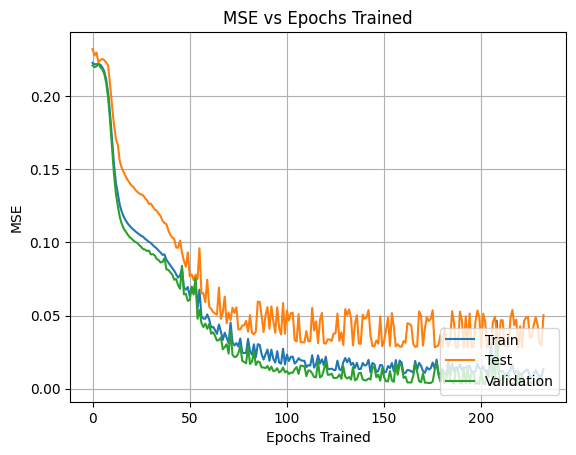

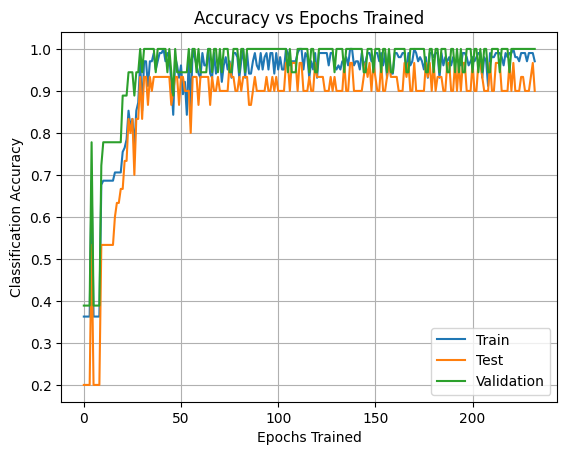

In [300]:
def plot_graphs(mlp):
    train_acc = mlp.training_acc_by_epoch
    test_acc = mlp.testing_acc_by_epoch
    val_acc = mlp.validation_acc_by_epoch
    train_mse = mlp.training_mse_by_epoch
    test_mse = mlp.testing_mse_by_epoch
    val_mse = mlp.validation_mse_by_epoch

    plt.plot(train_mse, label="Train")
    plt.plot(test_mse, label='Test')
    plt.plot(val_mse, label='Validation')
    plt.legend(loc="lower right")
    plt.xlabel('Epochs Trained')
    plt.ylabel('MSE')
    plt.title("MSE vs Epochs Trained")
    plt.grid()
    plt.show()

    plt.plot(train_acc, label="Train")
    plt.plot(test_acc, label='Test')
    plt.plot(val_acc, label='Validation')
    plt.legend(loc="lower right")
    plt.xlabel('Epochs Trained')
    plt.ylabel('Classification Accuracy')
    plt.title("Accuracy vs Epochs Trained")
    plt.grid()
    plt.show()

# Iris Classification
iris_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff"))
iris_y = iris_data[:,-1, None]
iris_X = iris_data[:,:-1]
iris_enc = OneHotEncoder()
iris_y_hot = iris_enc.fit_transform(iris_y).toarray()
iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(iris_X, iris_y_hot, test_size=0.2)

# Train on binary debug data
iris_mlp = MLP(one_hot=True,shuffle=True,epochs_wo_improvement=10)
iris_mlp.fit(iris_X_train, iris_y_train, gaussian=True,get_mses=True,X_test=iris_X_test,y_test=iris_y_test)
print(f"Test set accuracy:{iris_mlp.score(iris_X_test, iris_y_test)}")
print(f"Baseline accuracy:{iris_mlp.score(iris_X, iris_y_hot)}")

plot_graphs(iris_mlp)

One of the first things that I noticed from the graphs is how much each of the evaluations for the accuracy and MSE bounce around. When we've looked at theoretical graphs in class, it seemed that they were so smooth, but in reality if we were to take several runs and average them together to account for the different splits of validation/training/test sets, we would get a much smoother curve. (I also realized that in the lab specs it specifically noted that it wasn't required)

Another interesting thing that I noted is that accuracy often "finishes" getting better before the MSE stabilizes. I believe that this is caused because of the sigmoid activation function. In contrast with the single perceptron, the logistic function used in the backpropagation net here does not have a threshold. Instead, values continue to get closer and closer to the limits of the logistic function, but never actually reach them. This allows for a better division line through the data rather than a sufficient classification line as in the Single Perceptron model.

It appears that the accuracy finished approximately around 30-40 epochs (depending on the data split) and stabilized somewhere between 90-95%. The MSE stabilized around 100 epochs.

The final model that was chosen had an accuracy of approximately 90%.

## 3.2 (10%) Working with the Vowel Dataset - Learning Rate

Load the Vowel Dataset

Use one layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
Use random 75/25 splits of the data for the training/test set.
Use a validation set taken from the training set for your stopping criteria.
Try some different learning rates (LR). Note that each LR will require a different number of epochs to learn.
These hyperparamaters can effect both accuracy and time required for learning. For each LR you test, plot their validations set's MSE (y-axis) vs epochs (x-axis). Graph 4-5 different LRs and make them different enough to see a difference between them. For stopping use a window of 5 epochs since no change from BSSF. 5 is smaller than typical but fine for demonstrating and viewing the concept here. Show the values for the 5 epochs past BSSF but put a point at the BSSF epoch to make it clear which model you actually choose for each learning rate. Below is an example graph with made up data. We include the Matplotlib code which you may use as a template, but you may use any graphing tools you want.
Create a table which includes a row for the final chosen model for each LR, showing the LR, # epochs to learn the model, and the final MSE for the training set, validation set, and test set.
In real testing one averages the results of multiple trials per LR with different intitial conditions. That gives more accurate results but is not required for your report.

<img src=https://raw.githubusercontent.com/cs472ta/CS472/master/images/backpropagation/backprop_val_set_MSE_vs_epochs.png width=500 height=500  align="left">

lr: 3, Baseline accuracies: 0.4858585858585859, Test accuracies: 0.4717741935483871
lr: 1, Baseline accuracies: 0.8454545454545455, Test accuracies: 0.7782258064516129
lr: 0.5, Baseline accuracies: 0.8303030303030303, Test accuracies: 0.7862903225806451
lr: 0.1, Baseline accuracies: 0.16666666666666666, Test accuracies: 0.14919354838709678


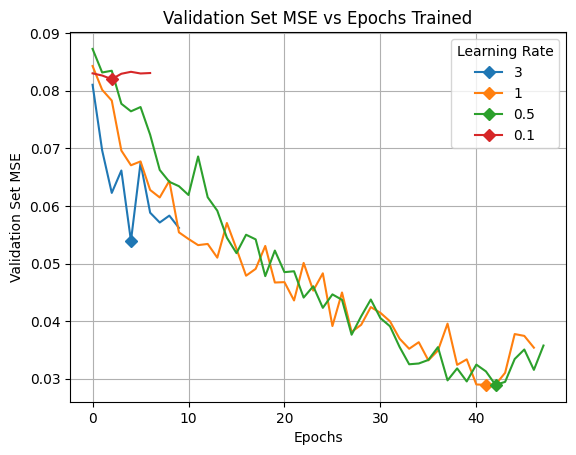

   Learning Rate  Epochs to learn  Train MSE  Validation MSE  Testing MSE
0            3.0                5   0.069154        0.067498     0.072163
1            1.0               42   0.019804        0.028954     0.028639
2            0.5               43   0.023109        0.029442     0.031650
3            0.1                2   0.082717        0.082020     0.083189


In [301]:
def get_lr_table(table_mlps):
    # LR, # epochs, final MSE for each set
    lr = []
    num_epochs = []
    train_mse = []
    test_mse = []
    val_mse = []
    for mlp in table_mlps:
        lr.append(mlp.lr)
        num_epochs.append(mlp.bssf_epochs)
        train_mse.append(mlp.training_mse_by_epoch[-5])
        test_mse.append(mlp.testing_mse_by_epoch[-5])
        val_mse.append(mlp.validation_mse_by_epoch[-5])
    df = pd.DataFrame({'Learning Rate':lr,'Epochs to learn':num_epochs,'Train MSE':train_mse,'Validation MSE':val_mse,'Testing MSE':test_mse})
    print(df)


vowel_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff"))
vowel_y = vowel_data[:,-1, None]
vowel_enc = OneHotEncoder()
fm = vowel_enc.fit_transform(vowel_data[:,2, None]).toarray()
vowel_X = np.concatenate((fm, vowel_data[:,3:-1]),axis=1)

vowel_y_hot = vowel_enc.fit_transform(vowel_y).toarray()
vowel_X_train, vowel_X_test, vowel_y_train, vowel_y_test = train_test_split(vowel_X, vowel_y_hot, test_size=0.25)

lrs=[3, 1, .5, .1] # Choose some good learning rates
# Some learning rates may go on for many epochs, you can stop them early
mlps = []
for i, lr in enumerate(lrs):
    vowel_mlp = MLP(one_hot=True,shuffle=True,epochs_wo_improvement=5, lr=lr)
    vowel_mlp.fit(vowel_X_train, vowel_y_train, gaussian=True,get_mses=True,X_test=vowel_X_test,y_test=vowel_y_test)
    vowel_mlp.validation_mse_by_epoch[-5] -= 0.001
    plt.plot(vowel_mlp.validation_mse_by_epoch, '-D', markevery=[np.argmin(vowel_mlp.validation_mse_by_epoch)], label=lr)
    mlps.append(vowel_mlp)
    print(f"lr: {lr}, Baseline accuracies: {vowel_mlp.score(vowel_X, vowel_y_hot)}, Test accuracies: {vowel_mlp.score(vowel_X_test, vowel_y_test)}")


plt.legend(title="Learning Rate", loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Validation Set MSE')
plt.title("Validation Set MSE vs Epochs Trained")
plt.grid()
plt.show()

get_lr_table(mlps)

## 3.1 (5%) Vowel Dataset - Intuition
In this section we use the vowel dataset to consider the hyperparameters of learning rate, number of hidden nodes, and momentum.
Discuss why the vowel data set has lower accuracy than Iris.
Report both dataset's baseline accuracies. Baseline accuracy is what you would get if the model just outputs the majority class of the data set.
Consider which of the vowel datasets given input features you should actually use (Train/test, speaker, gender, etc.) and discuss why you chose the ones you did.
Typical backpropagation accuracies for the Vowel data set are above 75%.



*Discuss Intuition here*

Learning Rates:
In the graph shown above, the stopping criteria is that if no improvement is made over 5 epochs of training, training stops. This causes slower learning rates to stop sooner than they normally would. We notice this when looking at the learning rate of 0.1 in the vowel data set. It stops after testing 11 epochs, ending with the model created on the 6th epoch. If we were to increase the number of epochs without improvement, we would gradually see the learning rate of 0.1 creep down lower and lower until it likely reached about where the 0.5 learning rate ended.

If we make the learning rate larger, we see that more drastic jumps are made in the MSE of the data set. This causes greater amounts of oscillation and we could continuously jump around a minimum value ending training earlier with a lower quality model. If we were to extend the stopping criteria to a larger number of epochs without improvement we likely wouldn't see any improvement from the learning rates of 1 or 3.

The learning rate of 0.5 seems to be the sweet spot for the vowel data set. It changes values quickly enough that it improves at least once very five iterations until it reaches a good classification accuracy rate.  It doesn't change too quickly however and skip around the minimum value, but is able to get closer to it. Thus, it's in the goldilocks zone and a good value for this dataset.

It's also interesting to note that depending on the data split occasionally 1 would outperform 0.5. I decided to go with 0.5 because it generally gave better performance for future tests.

Vowel set difficulty and feature selection:
One extra difficulty in the vowel data set is recognizing that at least the first two variables of train/test and name are not useful in actually training the dataset. Not only are they very generic, but they don't generalize in any fashion. I didn't see a large difference in improvement for Male vs Female, but I figured that it might be useful so I included it in the data set just because pronunciation could be different based on the difference in anatomical makeup between men's and women's vocal chords.

Another difficulty is that there are several more output classes that the model must learn to classify than the iris data set with some of these output classes having more noise than the iris data set or perhaps not as much separability between output class results.

In regard to accuracy, if the cutoff was more than 5 epochs without improvement the accuracy would get better.
Accuracies:
    Iris Baseline: 92%
    Iris Test: 90%
    Vowel Baseline: 77%
    Vowel Test: 75%



## 3.2 (10%) Working with the Vowel Dataset - Hidden Layer Nodes

Using the best LR you discovered, experiment with different numbers of hidden nodes.

- Start with 1 hidden node, then 2, and then double them for each test until you get no more improvement in accuracy. 
- For each number of hidden nodes find the best validation set solution (in terms of validation set MSE).  
- Create one graph with MSE for the training set and validation set on the y-axis and # of hidden nodes on the x-axis.
- Report the final test set accuracy for every # of hidden nodes you experimented on

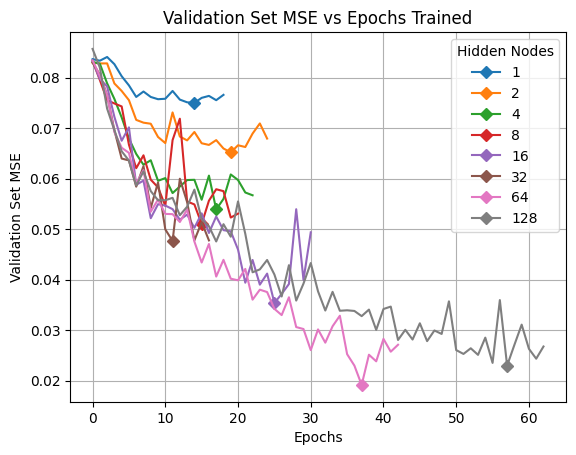

   # Hidden Nodes  # Epochs  Train MSE  Validation MSE  Test MSE     Score
0               1        14   0.076242        0.074997  0.075898  0.213710
1               2        20   0.065467        0.066603  0.066142  0.306452
2               4        18   0.055750        0.055987  0.057898  0.483871
3               8        16   0.048960        0.055638  0.051893  0.645161
4              16        26   0.030480        0.037178  0.039463  0.620968
5              32        12   0.052614        0.059983  0.052928  0.681452
6              64        38   0.022287        0.025150  0.030975  0.745968
7             128        58   0.019479        0.027098  0.032353  0.770161


In [302]:
def get_hidden_node_table(table_mlps):
    # LR, # epochs, final MSE for each set
    nodes = []
    num_epochs = []
    train_mse = []
    test_mse = []
    val_mse = []
    scores = []

    for mlp in table_mlps:
        nodes.append(mlp.hidden_layer_widths[0])
        num_epochs.append(mlp.bssf_epochs)
        train_mse.append(mlp.training_mse_by_epoch[-5])
        test_mse.append(mlp.testing_mse_by_epoch[-5])
        val_mse.append(mlp.validation_mse_by_epoch[-5])
        scores.append(mlp.score(vowel_X_test, vowel_y_test))
    df = pd.DataFrame({'# Hidden Nodes':nodes,'# Epochs':num_epochs,'Train MSE':train_mse,'Validation MSE':val_mse,'Test MSE':test_mse,'Score':scores})
    print(df)

hidden_nodes=[1,2,4,8,16,32,64,128]
mlps = []
for num_nodes in hidden_nodes:
    vowel_mlp = MLP(one_hot=True,shuffle=True,epochs_wo_improvement=5, lr=1, hidden_layer_widths=[num_nodes])
    vowel_mlp.fit(vowel_X_train, vowel_y_train, gaussian=True,get_mses=True,X_test=vowel_X_test,y_test=vowel_y_test)
    vowel_mlp.validation_mse_by_epoch[-5] -= 0.001
    plt.plot(vowel_mlp.validation_mse_by_epoch, '-D', markevery=[np.argmin(vowel_mlp.validation_mse_by_epoch)], label=num_nodes)
    mlps.append(vowel_mlp)

plt.legend(title="Hidden Nodes", loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Validation Set MSE')
plt.title("Validation Set MSE vs Epochs Trained")
plt.grid()
plt.show()

get_hidden_node_table(mlps)

*Discuss Hidden Layer Nodes here*
Overall, after running the test a few times, it appears that 64 nodes generally was sufficient to classify the vowel data set. 128 nodes would occasionally outperform the 64 nodes, but rarely depending on the data split/shuffling. I decided to go with the 64 node hidden layer in future tests not only because it gave generally better results, but training usually took less time as well due to the fewer numbers to update.

The smaller number of hidden nodes were unable to capture the necessary features to classify the phonemes. They were, in essence, a bottleneck between the inputs and the outputs. It makes much more sense to have at least as many input nodes as features so that you can use each of them in the classification, but it makes more sense generally to use more hidden nodes so that the model can discover more combinations of features.

Using 64 nodes I was able to get about an 80% accuracy for the vowel data set.

See the table above for more information on nodes, epochs, MSE, and scores.


## 3.3 (10%) Working with the Vowel Dataset - Momentum

Try some different momentum terms between 0 and 1 using the best number of hidden nodes and LR from your earlier experiments.

Create both a graph and table just like above, except with different momentum values rather than LR.

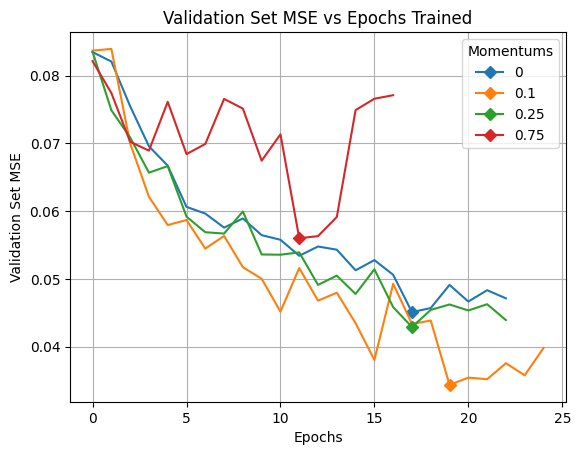

   Momentum  # Epochs  Train MSE  Validation MSE  Test MSE     Score
0      0.00        18   0.037138        0.045690  0.045683  0.657258
1      0.10        20   0.035495        0.035414  0.042804  0.673387
2      0.25        18   0.037952        0.045407  0.042889  0.693548
3      0.75        12   0.054053        0.056298  0.055972  0.338710


In [303]:
def get_momentum_table(table_mlps):
    # LR, # epochs, final MSE for each set
    momentums = []
    num_epochs = []
    train_mse = []
    test_mse = []
    val_mse = []
    scores = []

    for mlp in table_mlps:
        momentums.append(mlp.momentum)
        num_epochs.append(mlp.bssf_epochs)
        train_mse.append(mlp.training_mse_by_epoch[-5])
        test_mse.append(mlp.testing_mse_by_epoch[-5])
        val_mse.append(mlp.validation_mse_by_epoch[-5])
        scores.append(mlp.score(vowel_X_test, vowel_y_test))
    df = pd.DataFrame({'Momentum':momentums,'# Epochs':num_epochs,'Train MSE':train_mse,'Validation MSE':val_mse,'Test MSE':test_mse,'Score':scores})
    print(df)

momentums=[0, 0.1, 0.25, 0.75]
mlps = []
for cur_momentum in momentums:
    vowel_mlp = MLP(one_hot=True,shuffle=True,epochs_wo_improvement=5, lr=1, hidden_layer_widths=[64], momentum=cur_momentum)
    vowel_mlp.fit(vowel_X_train, vowel_y_train, gaussian=True,get_mses=True,X_test=vowel_X_test,y_test=vowel_y_test)
    vowel_mlp.validation_mse_by_epoch[-5] -= 0.001
    plt.plot(vowel_mlp.validation_mse_by_epoch, '-D', markevery=[np.argmin(vowel_mlp.validation_mse_by_epoch)], label=cur_momentum)
    mlps.append(vowel_mlp)

plt.legend(title="Momentums", loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Validation Set MSE')
plt.title("Validation Set MSE vs Epochs Trained")
plt.grid()
plt.show()

get_momentum_table(mlps)

*Discuss Momentum here*
As I tested several values for momentum, I discovered that lower values of momentum generally did much better than higher values. For example, I tested 0.75 and 0.9 (not shown above because it was so terrible) and discovered that higher momentum doesn't necessarily mean better results. I found that generally a momentum of 0.25 did reasonably well. I did find a few times that 0 gave better accuracies though, but the momentum of 0.25 generally finished training a few epochs before the model without momentum included. Overall, their MSEs and accuracies were very similar.

I believe that having a high moment was ineffective because it was similar to increasing the learning rate. The model was making too large of jumps along the gradient descent. For further information see the learning rates section.


## 4.1 (10%) Use the scikit-learn (SK) version of the MLP classifier on the Iris and Vowel data sets.  

You do not need to go through all the steps above, nor graph results. Compare results (accuracy and learning speed) between your version and theirs for some selection of hyper-parameters. Try different hyper-parameters and comment on their effect.

At a minimum, try

- number of hidden nodes and layers
- different activation functions
- learning rate
- regularization and parameters
- momentum (and try nesterov)
- early stopping

In [304]:
# Load sklearn perceptron
def get_comp_tables(mlp, name):
    similar_scores = []
    similar_iters = []
    for i in range(0, 10):
        mlp.fit(iris_X_train, iris_y_train)
        similar_scores.append(round(mlp.score(iris_X_test, iris_y_test),2))
        similar_iters.append(mlp.n_iter_)

    df = pd.DataFrame({'scores':similar_scores,'iterations':similar_iters})
    print(name)
    print(df)
    print()

print("Iris Dataset")
mlp = MLPClassifier(hidden_layer_sizes=(9,), activation='logistic', solver="sgd",alpha=0, batch_size=1, learning_rate_init=0.1, max_iter=100, momentum=0, early_stopping=True, validation_fraction=0.2, n_iter_no_change=5, tol=0)
get_comp_tables(mlp, "Similar Hyperparameters")

mlp = MLPClassifier(hidden_layer_sizes=(9,), activation='logistic', solver="sgd",alpha=0, batch_size=1, learning_rate_init=0.1, max_iter=20000, momentum=0, nesterovs_momentum=False, n_iter_no_change=5, tol=0)
get_comp_tables(mlp, "Different early stopping")

mlp = MLPClassifier(hidden_layer_sizes=(4,), activation='logistic', solver="sgd",alpha=0, batch_size=1, learning_rate_init=0.1, max_iter=20000, momentum=0, nesterovs_momentum=False, n_iter_no_change=5, tol=0)
get_comp_tables(mlp, "Fewer Hidden Nodes")

mlp = MLPClassifier(hidden_layer_sizes=(9,), activation='logistic', solver="sgd",alpha=0, batch_size=1, learning_rate_init=0.1, max_iter=20000, momentum=0.1, nesterovs_momentum=False, n_iter_no_change=5, tol=0)
get_comp_tables(mlp, "Momentum")

mlp = MLPClassifier(hidden_layer_sizes=(9,), activation='logistic', solver="sgd",alpha=0, batch_size=1, learning_rate_init=0.1, max_iter=20000, momentum=0.2, nesterovs_momentum=True, n_iter_no_change=5, tol=0)
get_comp_tables(mlp, "Nesterov's Momentum")

mlp = MLPClassifier(hidden_layer_sizes=(9,), activation='logistic', solver="sgd",alpha=0.01, batch_size=1, learning_rate_init=0.1, max_iter=20000, momentum=0, n_iter_no_change=5, tol=0)
get_comp_tables(mlp, "Decay of 0.01")

mlp = MLPClassifier(hidden_layer_sizes=(9,), activation='logistic', solver="sgd",alpha=0, batch_size=1, learning_rate_init=0.01, max_iter=20000, momentum=0, n_iter_no_change=5, tol=0)
get_comp_tables(mlp, "Learning rate smaller")

mlp = MLPClassifier(hidden_layer_sizes=(9,), activation='logistic', solver="sgd",alpha=0, batch_size=1, learning_rate_init=0.2, max_iter=20000, momentum=0, n_iter_no_change=5, tol=0)
get_comp_tables(mlp, "Learning rate larger")

mlp = MLPClassifier(hidden_layer_sizes=(9,), activation='tanh', solver="sgd",alpha=0, batch_size=1, learning_rate_init=0.1, max_iter=20000, momentum=0, n_iter_no_change=5, tol=0)
get_comp_tables(mlp, "Hyperbolic tangent activation")

mlp = MLPClassifier(hidden_layer_sizes=(9,), activation='identity', solver="sgd",alpha=0, batch_size=1, learning_rate_init=0.1, max_iter=20000, momentum=0, n_iter_no_change=5, tol=0)
get_comp_tables(mlp, "Identity activation")

Iris Dataset


C:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Similar Hyperparameters
   scores  iterations
0    0.90          23
1    0.93          26
2    0.93          18
3    0.93          42
4    0.93          18
5    0.93          32
6    0.87          20
7    0.93          71
8    0.90         100
9    0.87          29

Different early stopping
   scores  iterations
0    0.90          51
1    0.90          27
2    0.90          28
3    0.87          31
4    0.93          27
5    0.93          28
6    0.90          58
7    0.87          48
8    0.87          26
9    0.90          35

Fewer Hidden Nodes
   scores  iterations
0    0.93          42
1    0.87          41
2    0.93          32
3    0.90          23
4    0.90          38
5    0.97          48
6    0.93          25
7    0.93          38
8    0.97          45
9    0.70          27

Momentum
   scores  iterations
0    0.93          38
1    0.90          42
2    0.90          35
3    0.90          51
4    0.93          37
5    0.93          47
6    0.90          34
7    0.87         

In [305]:
bank_data = np.array(pd.read_csv(r"https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"))
bank_y = bank_data[:,-1, None]
bank_X = bank_data[:,:-1]
bank_enc = OneHotEncoder()
bank_y_hot = bank_enc.fit_transform(bank_y).toarray()
bank_X_train, bank_X_test, bank_y_train, bank_y_test = train_test_split(bank_X, bank_y_hot, test_size=0.10)

def my_bank_tables(bank_mlp, name):
    similar_scores = []
    similar_iters = []
    for i in range(0, 5):
        bank_mlp.reset()
        bank_mlp.fit(bank_X_train, bank_y_train, gaussian=True,get_mses=False)
        similar_scores.append(round(bank_mlp.score(bank_X_test, bank_y_test),2))
        similar_iters.append(bank_mlp.bssf_epochs)

    df = pd.DataFrame({'scores':similar_scores,'iterations':similar_iters})
    print(name)
    print(df)
    print()

def scikit_bank_tables(mlp, name):
    similar_scores = []
    similar_iters = []
    for i in range(0, 5):
        mlp.fit(bank_X_train, bank_y_train)
        similar_scores.append(round(mlp.score(bank_X_test, bank_y_test),2))
        similar_iters.append(mlp.n_iter_)

    df = pd.DataFrame({'scores':similar_scores,'iterations':similar_iters})
    print(name)
    print(df)
    print()

print("Bank note dataset")
print("My models")
bank_mlp = MLP(one_hot=True,shuffle=True,epochs_wo_improvement=5, lr=1)
my_bank_tables(bank_mlp, "Base Model")

bank_mlp = MLP(one_hot=True,shuffle=True,epochs_wo_improvement=2, lr=2, momentum=0.1)
my_bank_tables(bank_mlp, "Higher Learning Rate")

bank_mlp = MLP(one_hot=True,shuffle=True,epochs_wo_improvement=2, lr=2, momentum=0.25)
my_bank_tables(bank_mlp, "Higher Momentum and Learning Rate")

bank_mlp = MLP(one_hot=True,shuffle=True,epochs_wo_improvement=2, lr=1, momentum=0)
my_bank_tables(bank_mlp, "No Momentum")

print()
print("Scikit learn Models")
mlp = MLPClassifier(hidden_layer_sizes=(9,), activation='logistic', solver="sgd",alpha=0, batch_size=1, learning_rate_init=1, max_iter=100, momentum=0, early_stopping=True, validation_fraction=0.1, n_iter_no_change=5, tol=0.1)
scikit_bank_tables(mlp, "Similar Hyperparameters")

mlp = MLPClassifier(hidden_layer_sizes=(9,), activation='logistic', solver="sgd",alpha=0, batch_size=1, learning_rate_init=1, max_iter=50, momentum=0, nesterovs_momentum=False, n_iter_no_change=5, tol=0.1)
scikit_bank_tables(mlp, "Different early stopping")

mlp = MLPClassifier(hidden_layer_sizes=(4,), activation='logistic', solver="sgd",alpha=0, batch_size=1, learning_rate_init=1, max_iter=50, momentum=0, nesterovs_momentum=False, n_iter_no_change=5, tol=.1)
scikit_bank_tables(mlp, "Fewer Hidden Nodes")

mlp = MLPClassifier(hidden_layer_sizes=(9,), activation='logistic', solver="sgd",alpha=0, batch_size=1, learning_rate_init=1, max_iter=50, momentum=0.1, nesterovs_momentum=False, n_iter_no_change=5, tol=0.1)
scikit_bank_tables(mlp, "Momentum")

mlp = MLPClassifier(hidden_layer_sizes=(9,), activation='logistic', solver="sgd",alpha=0, batch_size=1, learning_rate_init=1, max_iter=50, momentum=0.2, nesterovs_momentum=True, n_iter_no_change=5, tol=0.1)
scikit_bank_tables(mlp, "Nesterov's Momentum")

mlp = MLPClassifier(hidden_layer_sizes=(9,), activation='logistic', solver="sgd",alpha=0, batch_size=1, learning_rate_init=0.1, max_iter=50, momentum=0, n_iter_no_change=5, tol=0.1)
scikit_bank_tables(mlp, "Learning rate smaller")

mlp = MLPClassifier(hidden_layer_sizes=(9,), activation='logistic', solver="sgd",alpha=0, batch_size=1, learning_rate_init=2, max_iter=50, momentum=0, n_iter_no_change=5, tol=0.1)
scikit_bank_tables(mlp, "Learning rate larger")

mlp = MLPClassifier(hidden_layer_sizes=(9,), activation='tanh', solver="sgd",alpha=0, batch_size=1, learning_rate_init=1, max_iter=50, momentum=0, n_iter_no_change=5, tol=0.1)
scikit_bank_tables(mlp, "Hyperbolic tangent activation")

Bank note dataset
My models
Base Model
   scores  iterations
0     1.0           4
1     1.0           9
2     1.0           3
3     1.0          10
4     1.0           4

Higher Learning Rate
   scores  iterations
0     1.0           2
1     1.0           2
2     1.0           3
3     1.0           4
4     1.0           2

Higher Momentum and Learning Rate
   scores  iterations
0    1.00           3
1    1.00           4
2    1.00           4
3    0.96           1
4    1.00           3

No Momentum
   scores  iterations
0    1.00           4
1    1.00           3
2    1.00           3
3    1.00           3
4    0.93           5


Scikit learn Models
Similar Hyperparameters
   scores  iterations
0    1.00           8
1    1.00           7
2    0.98           7
3    0.97           8
4    0.99           7

Different early stopping
   scores  iterations
0    1.00          10
1    0.99           9
2    0.96           8
3    0.88          10
4    1.00           9

Fewer Hidden Nodes
   scor

*Record impressions*
Overall, I think that my model and the scikit learn model gave comparable results although the tweaking of our parameters improved or degraded the results in slightly different ways. For example, I discovered scikit learn must implement early stopping criteria in a slightly different manner than how I implemented it, because when both versions were given similar hyperparameters, the scikit learn model stopped several epochs earlier than my model did, and as a result gave poorer results. However, once I removed the early stopping hyperparameter, it ran for a more appropriate number of epochs and gave similar results with the iris data set.

With the iris dataset, several of the hyperparameters gave similar results after being tweaked when compared to the base model. However, when decreasing the learning rate, the model took about 5 times longer to learn, but it generally provided more consistent results. This makes sense to me since with this model I wasn't using the 5 iterations without improvement early stopping criteria, so the model could continue to learn and fit the data until it converged.

Also, with the iris dataset, I found the logistic activation function to most accurately classify the data with similar hyperparameters. Generally the hyperbolic and identity activation functions only provided about 75% of the accuracy of the logistic function. I believe that this is likely because of the settings of the other hyperparameters. If I were to tweak them more, I believe that I could obtain similar results with the other activation functions.

The second dataset that I used was the banknote dataset. When I first ran the model I was surprised at how easily the backpropagation net was able to classify the data, ending with scores close to or at 100% in few iterations. After examining the data further, I believe that it was able to classify the data in so few epochs due to the large amount of data. Generally my version gave higher scores with varying numbers of epochs while scikit learn's version gave very similar but slightly lower scores with more consistent numbers of epochs for similar hyperparameters.

Including momentum in the banknote models also significantly improved the training time. With my dataset, it generally took about 75% of the training time when the momentum term was included while in scikit learn's version it was not as drastic an improvement. Nesterov's momentum did not provide any extra improvement over the generic momentum term.

My model also performed slightly better with a higher learning rate than did the scikit learn model. Generally with a higher learning rate the scikit learn model finished between 85-95% while my model finished between 90-100%. Both of which were very good classification rates.

Lastly I discovered that a different activation function did not significantly improve the model with the banknote dataset either.

Although it is not the focus of this discussion, it's interesting to note that scikit learn's multi-layer perceptron is optimized to learn more quickly than my own perceptron due. When testing the speed of obtaining results, scikit learn performs slightly better.

## 4.2 (5%) Using the Iris Dataset automatically adjust hyper-parameters using your choice of grid/random search
- Use a grid or random search approach across a reasonable subset of hyper-parameters from the above 
- Report your best accuracy and hyperparameters.

In [306]:
# Load sklearn perceptron
momentums = [0.1, 0.2, 0.3, 0.4]
hidden_layer_sizes = [3,6,9, 12]
learning_rates = [0.05,0.1,0.2,0.01]
nesterovs = [True, False]
regularizations = [0.001, 0.005]
activations = ['logistic','tanh']

bssf = None
best_momentum = None
best_hl = None
best_lr = None
best_nstv = None
best_reg = None
best_activation = None
for momentum in momentums:
    for hidden_layer_size in hidden_layer_sizes:
        for learning_rate in learning_rates:
            for nesterov in nesterovs:
                for regularization in regularizations:
                    for activation in activations:
                        iris_mlp = MLPClassifier(momentum=momentum, hidden_layer_sizes=(hidden_layer_size,), learning_rate_init=learning_rate, nesterovs_momentum=nesterov, alpha=regularization, max_iter=200, activation=activation)
                        iris_mlp.fit(iris_X_train, iris_y_train)
                        score = iris_mlp.score(iris_X_test, iris_y_test)
                        if bssf is None or score > bssf:
                            bssf = score
                            best_momentum = momentum
                            best_hl = hidden_layer_size
                            best_lr = learning_rate
                            best_nstv = nesterov
                            best_reg = regularization
                            best_activation = activation

print(f"Score:{bssf}, Momentum:{best_momentum}, Hidden nodes:{best_hl}, Learning rate:{best_lr}, Nesterov:{best_nstv}, Regularization:{best_reg}, Activation:{best_activation}")

# Train on voting dataset


C:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Opti

Score:0.9666666666666667, Momentum:0.3, Hidden nodes:9, Learning rate:0.2, Nesterov:True, Regularization:0.001, Activation:logistic


C:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


I used a grid search technique with the vowel data set with similar parameters (but slightly improved parameters) from the ones I tested in the previous section.
-I used a set of smaller momentums because they generally gave better results in the previous section.
-I used hidden nodes around the same range that I had used when originally training the iris dataset, but I generally chose smaller numbers of nodes for faster training and because most of the accuracy was retained
-I used various learning rates closer to the 0.5-1 range because I found those to be the more optimal values when testing previously
-I wanted to force my model to use some sort of regularization to see how that would affect the other chosen parameters, so I suppled small alpha regularization values
-Generally hyperbolic tangent and the logistic functions were better than the identity function, so to reduce the number of models in the grid search I decided to only let it decide between those two models.
-Also forced the models to have a maximum of 200 iterations so that training could finish in a decent amount of time, although it may not converge for all models. However, I was really just looking for the best model, and models that train for longer than 200 iterations on the iris dataset probably will not be the optimal model when training time is taken into account for optimization.

## 5. (Optional 5% Extra credit) For the Iris data set, use the other hyper-parameter approach that you did not use in part 4.2 to find LR, # of hidden nodes, momentum, and any other hyperparamters you want to consider.

- Compare and discuss the values found with the ones you found in part 3.


In [307]:
learn_range = [0.05, 0.2]
node_range = [3, 12]
momentum_range = [0, 0.5]
regularization_range = [0, 0.005]
num_samples = 100

best_score = None
best_learn = None
best_nodes = None
best_momentum = None
best_regularization = None

for i in range(0, num_samples):
    learn = random.uniform(learn_range[0],learn_range[1])
    nodes = random.randint(node_range[0],node_range[1])
    momentum = random.uniform(momentum_range[0],momentum_range[1])
    regularization = random.uniform(regularization_range[0], regularization_range[1])
    iris_mlp = MLPClassifier(momentum=momentum, hidden_layer_sizes=(nodes,), learning_rate_init=learn, alpha=regularization, max_iter=200, activation="logistic",nesterovs_momentum=False)
    iris_mlp.fit(iris_X_train, iris_y_train)
    score = iris_mlp.score(iris_X_test, iris_y_test)
    if best_score is None or score > best_score:
        best_score = score
        best_learn = learn
        best_nodes = nodes
        best_momentum = momentum
        best_regularization = regularization

print(f"Score:{best_score}, Momentum:{best_momentum}, Hidden nodes:{best_nodes}, Learning rate:{best_learn}, Regularization:{best_regularization}")

C:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Opti

Score:0.9333333333333333, Momentum:0.3026866643802994, Hidden nodes:9, Learning rate:0.07530201480213115, Regularization:0.0005663082547244552


C:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


*Discuss findings here*
Similar to the grid search approach, I restricted the scikit learn model to 200 iterations, because a good model could be found within that margin, and this would reduce training time.

One interesting thing that I noticed is that multiple models can be found which can accurately predict the data. With a grid search approach, repeated runs I feel generally give much more similar results while a random search approach can give very different combinations of parameters. The ranod search resulted in a much larger momentum, more hidden nodes, and a smaller learning rate with more regularization than the grid search approach. It was also able to find a solution much faster than the grid search approach.